# Recommendations with IBM


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import operator
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel 

%matplotlib inline

df = pd.read_csv('IBM_Project/user-item-interactions.csv')
df_content = pd.read_csv('IBM_Project/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2



### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>



In [92]:
#check datatypes of df columns
df.dtypes

article_id    float64
title          object
email          object
dtype: object

In [93]:
df.shape

(45993, 3)

In [94]:
#convert article_id to str datatype
df['article_id'] = df['article_id'].astype(str)

In [95]:
#number of articles being read by users
len(np.unique(df['article_id']))

714

In [48]:
#summary statistics of article column
df['article_id'].describe()

count      45993
unique       714
top       1429.0
freq         937
Name: article_id, dtype: object

In [49]:
#summary statistics of the email column of df
df['email'].describe()

count                                        45976
unique                                        5148
top       2b6c0f514c2f2b04ad3c4583407dccd0810469ee
freq                                           364
Name: email, dtype: object

In [50]:
#Explore the dataset of article desciption
df_content.shape

(1056, 5)

In [51]:
#numbers of articles present in the database
len(np.unique(df_content['article_id']))

1051

In [52]:
# Find and explore duplicate articles
df_content[df_content.duplicated(['article_id'])]

,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [53]:
# Remove any rows that have the same article_id - only keep the first
df_content_unique = df_content.drop_duplicates(subset=['article_id'])

In [54]:
df_content_unique.shape

(1051, 5)

In [96]:
#This function maps the user email to a user_id column and removes the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

There is no ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

In [56]:
#This function ranks articles according to how much interactions they get and return the top n
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles  
    '''
    #group by users to get number of interactions on an article
    df_interaction = df.groupby(['article_id']).count().reset_index()
    
    #reformat dataframe
    df_interaction = df_interaction[['article_id','user_id']]
    df_interaction.columns = ['article_id','user_count']
    
    #retrieve ids of top n articles
    article_ids = df_interaction.nlargest(n,'user_count')['article_id'].tolist()
    
    top_articles = df[df['article_id'].isin(article_ids)]['title'].tolist()
    top_articles = list(set(top_articles))

    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    '''
    #group by users to get number of interactions on an article
    df_interaction = df.groupby(['article_id']).count().reset_index()
    
    #reformat dataframe
    df_interaction = df_interaction[['article_id','user_id']]
    df_interaction.columns = ['article_id','user_count']
    
    #retrieve ids of top n articles
    top_articles = df_interaction.nlargest(n,'user_count')['article_id'].tolist()
    
   
    return top_articles # Return the top article ids

In [57]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['gosales transactions for logistic regression model', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'apache spark lab, part 1: basic concepts', 'use deep learning for image classification', 'insights from new york car accident reports', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'visualize car data with brunel', 'analyze energy consumption in buildings']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>

#### What to do:

* Create a user_item matrix

* **If a user has interacted with an article, we place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article would be a 1.  


* **If a user has not interacted with an item, then we place a zero where the user-row meets for that article-column**. 

In [58]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    #create a series to account for each interaction between user and article
    #add to the dataframe
    count = pd.Series([1])
    count = count.repeat(df.shape[0])
    count = list(count)
    df = df.assign(interaction=count)
    
    #create user_item matrix
    user_item = df.pivot_table(index='user_id',columns='article_id',values='interaction', aggfunc='max', fill_value=0)
    
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [59]:
#This function finds similar users to the given user
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered 
    '''
    #adjust user_id to match user_mat indexing
    user_id = user_id -1
    # compute similarity of each user to the provided user
    users_sim_mat = np.dot(user_item, np.transpose(user_item))
    
    # sort by similarity 
    user_sim = np.argsort(users_sim_mat[user_id])
    
    #remove user's own id
    user_sim_list = list(user_sim)
    user_sim_list.remove(user_id)
    
    #adjust back user_ids
    user_sim_ids = np.array(user_sim_list)
    user_sim_ids = user_sim_ids+1
    
    
    # create list of just the ids
    most_similar_users = list(user_sim_ids)
    most_similar_users = most_similar_users[::-1]
    
    return most_similar_users # return a list of the users in order from most to least similar
        

In [60]:
#This function returns the articles the system would recommend to each user. 
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    article_names = df.loc[df['article_id'].isin(article_ids)]['title'].tolist()
    article_names = list(set(article_names))
    
    return article_names 


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # retrieve ids of articles user has read
    user_row = user_item.loc[user_id,]
    article_ids = (user_row[user_row==1].index).tolist()
    article_names = df[df['article_id'].isin(article_ids)]['title'].tolist()
    #article_names = df_content[df_content['article_id'].isin(article_ids)]['doc_full_name'].tolist()
   # articles_names = list(set(article_names))
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    rec_ids = []
    #get articles already seen by user
    seen_articles = get_user_articles(user_id)
    seen_articles_ids = np.array(seen_articles[0])
    #get similar users
    sim_users = find_similar_users(user_id)
    #loop through users to get recommendations
    for user in sim_users:
        user_articles = get_user_articles(user)
        user_articles_ids = np.array(user_articles[0])
        unseen_article = np.setdiff1d(seen_articles_ids,user_articles_ids)
        rec_ids.extend(unseen_article)
        rec_ids = list(set(rec_ids))
        if len(rec_ids) >=m:
            break
    recs = rec_ids[:m]
    #recs = get_article_names(rec_ids)      
    
    
    return recs # return recommendations for this user_id   

In [61]:
# Check Results
get_article_names(user_user_recs(1, 10))

['python if statements explained (python for data science basics #4)',
 'jupyter notebook tutorial',
 'python for loops explained (python for data science basics #5)',
 'shiny: a data scientist’s best friend',
 'country statistics: life expectancy at birth',
 'introducing ibm watson studio ',
 'categorize urban density',
 'sector correlations shiny app',
 'uci ml repository: chronic kidney disease data set',
 'predict loan applicant behavior with tensorflow neural networking']

 To improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - we want to choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. 

In [62]:
def user_user_mat(user_item=user_item):
    '''
    INPUT:
    user_item: pandas dataframe with user ids as rows and article ids as column; 
                consists of 1's if user has read an article, 0 otherwise
    OUTPUT:
    similarity matrix of users to users
    
    DESCRIPTION:
    compute the dot product to get the similarity between each user and other users
    '''
    user_user_sim = np.dot(user_item, np.transpose(user_item))
    
    return user_user_sim

user_user_matrix = user_user_mat()

In [63]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    #adjust user id to match dot product indexing
    user_id = user_id-1
    
    user_user_sim = user_user_mat(user_item)
    #get similarities of the user with other users
    user_sim = user_user_sim[user_id]
    
    #group df by user_id to get number of article interactions of users
    df_new = df.groupby(['user_id'])['article_id'].count().reset_index()
    
    #rename columns
    df_new.columns = ['user_id','num_interactions']
    #extract only the interaction column to form a dataframe
    df_new = df_new[['num_interactions']]
    
    #create the similarity dataframe for the user_id
    neighbor_id = user_item.index
    id_sim = list(zip(neighbor_id, user_sim))
    sim_df = pd.DataFrame(id_sim, columns=['neighbor_id','similarity'])
    
    #re-adjust user id
    user_id = user_id +1
     
    #create neighbors_df dataframe
    neighbors_df = pd.concat([sim_df,df_new], axis=1)
    #insert the user_id
    neighbors_df.insert(0,'user_id',user_id)
    
    #format neighbors_df to exclude similarity with itself
    neighbors_df = neighbors_df[(neighbors_df['user_id']==user_id) &(neighbors_df['neighbor_id']!=user_id)]
    
    #sort neighbors_df by similarity, then by interaction
    neighbors_df = neighbors_df.sort_values(by=['similarity','num_interactions'], ascending=[False,False])
    
    
    return neighbors_df 


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    recs = []
    #group by article to get number of interactions on an article
    df_interaction = df.groupby(['article_id']).count().reset_index()
    
    #reformat dataframe
    df_interaction = df_interaction[['article_id','user_id']]
    df_interaction.columns = ['article_id','user_count']
    
    #rank the article interaction dataframe
    df_interaction = df_interaction.sort_values(by='user_count', ascending=False)
    
    #get neighbors dataframe of close users 
    neighbors_df = get_top_sorted_users(user_id)
    
    #articles user already interacted with
    seen_articles = df.loc[df['user_id']==user_id]['article_id'].tolist()
    
    for neighbor in neighbors_df['neighbor_id']:
        neighbor_article = df.loc[df['user_id']==neighbor]['article_id'].tolist()
        unseen_article = np.setdiff1d(seen_articles,neighbor_article)
        count = df_interaction.loc[df_interaction['article_id'].isin(unseen_article)]['user_count'].tolist()
        article_count= zip(unseen_article,count)
        #convert zip object to list
        article_count = list(article_count)
        #sort article_count to retreive article with most interactions
        sorted_art_count = sorted(article_count, key=operator.itemgetter(1))
        for article in sorted_art_count:
            recs.append(article[0])
        recs = list(set(recs))
            #if len(recs)>=10:
                #break
        if len(recs)>=m:
            break
            
   
    rec_names = df.loc[df['article_id'].isin(recs)]['title'].tolist()   
    rec_names = list(set(rec_names))
        

    
    return recs, rec_names

In [64]:
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1320.0', '232.0', '844.0']

The top 10 recommendations for user 20 are the following article names:
['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery', 'use the cloudant-spark connector in python notebook']


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations </a>

In [97]:
#Check for null values
df_content.isna().sum()

doc_body           14
doc_description     3
doc_full_name       0
doc_status          0
article_id          0
dtype: int64

In [98]:
df_content.dtypes

doc_body           object
doc_description    object
doc_full_name      object
doc_status         object
article_id          int64
dtype: object

In [99]:
#convert to float, then string
df_content['article_id'] = pd.to_numeric(df_content['article_id'],downcast="float")
df_content['article_id'] =df_content['article_id'].astype(str)

In [100]:
#number of articles that are not present in df_content dataframe
len(np.setdiff1d(df['article_id'].tolist(),df_content['article_id'].tolist()))

277

In [101]:
#Create a repository for all articles
article_df = df[['article_id','title']]
article_df_content = df_content[['article_id','doc_full_name']]
article_repo = article_df.merge(article_df_content,how='outer',on='article_id')

In [102]:
#drop duplicate rows
article_repo = article_repo.drop_duplicates(keep='first')

In [103]:
article_repo.head()

,article_id,title,doc_full_name
0,1430.0,"using pixiedust for fast, flexible, and easier...",NaN
336,1314.0,healthcare python streaming application demo,NaN
950,1429.0,use deep learning for image classification,NaN
1887,1338.0,ml optimization using cognitive assistant,NaN
2269,1276.0,deploy your python model as a restful api,NaN


In [104]:
#articles with missing title
missing_title = article_repo[article_repo['title'].isna()==True]
missing_title.head()

,article_id,title,doc_full_name
46284,1.0,NaN,Communicating data science: A guide to present...
46285,3.0,NaN,DataLayer Conference: Boost the performance of...
46286,5.0,NaN,Browsing PostgreSQL Data with Compose
46287,6.0,NaN,Upgrading your PostgreSQL to 9.5
46288,7.0,NaN,Data Wrangling at Slack


In [105]:
#fill in missing titles
article_repo['title'].fillna(article_repo['doc_full_name'], inplace=True)

In [106]:
#check missing title again to ensure all titles are filled
article_repo[article_repo['title'].isna()==True]

,article_id,title,doc_full_name


In [107]:
#drop the doc_full_name column
article_repo = article_repo[['article_id','title']]

In [108]:
#reset the index of the article_repo
article_repo.reset_index(drop=True, inplace=True)

In [109]:
#check for any null values in article_repo
article_repo.isna().sum()

article_id    0
title         0
dtype: int64

In [ ]:
#article_repo

The **title** column from df contains same data as **doc_full_name** from df_content so I decided to keep the title column and use for further analysis. Use the data from **doc_full_name** to fill the missing data in **title**.

In [110]:

tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(article_repo['title'])

In [111]:
#Cosine similarity measure is used to quantify similarities between documents
article_sim = linear_kernel(tfidf_matrix,tfidf_matrix)

In [112]:
def content_recs():
    recs = {}
    #loop through article_repo dataframe
    #sort each article's similarity with other articles
    for idx, row in article_repo.iterrows():
        similar_indices = article_sim[idx].argsort()[:-100:-1]
        similar_articles = [(article_sim[idx][i],article_repo['article_id'][i]) for i in similar_indices]
        recs[row['article_id']] = similar_articles[1:]
    return recs
recs = content_recs() 

In [113]:
def get_article_name(article_id):
    '''
    INPUT: (list) article id(s)
    OUTPUT: (str) name of article
    DESCRIPTION: get the article id and return the article's title
    '''
    return article_repo.loc[article_repo['article_id'].isin(article_id)]['title'].tolist()

In [115]:
#Make recommendation for existing users that has read atleast one article on the IBM Watson platform
def make_content_recs(article_id,num=10):
    '''
    INPUT: (str) article id
    
    OUTPUT: (list) recommended articles similar to given article
    
    DECSRIPTION: make recommendations based on article id
    '''
    recommendations = recs[article_id][:num]
    rec_ids = []
    for rec in recommendations:
        rec_ids.append(rec[1])
    return get_article_name(rec_ids)

In [116]:
# recommendations for a user who only has interacted with article id '1427.0'
make_content_recs('1427.0')

['python machine learning: scikit-learn tutorial',
 'machine learning for everyone',
 'ibm watson machine learning: get started',
 'leverage scikit-learn models with core ml',
 'what is machine learning?',
 'watson machine learning for developers',
 'from scikit-learn model to cloud with wml client',
 'from local spark mllib model to cloud with watson machine learning',
 'style transfer experiments with watson machine learning',
 'create a project for watson machine learning in dsx']

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part, I use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

In [118]:
# quick look at the matrix
user_item_matrix =user_item
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [119]:
df_train = df.head(40000)
df_test = df.tail(5993)
#This function converts both train set and test set into user_article matrices
def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    #retrieve user ids in both train and test dataset
    train_user_ids = np.unique(df_train['user_id'].tolist())
    test_user_ids = np.unique(df_test['user_id'].tolist())
    
    
    #split user_item matrix to train and test set
    user_item_train = user_item_matrix.loc[train_user_ids,]
    user_item_test = user_item_matrix.loc[test_user_ids,]
    
    #get all user ids and article ids in the test matrix 
    test_idx = test_user_ids
    test_arts = np.unique(df_test['article_id'].tolist())
      
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [120]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)

In [121]:
u_train.shape, s_train.shape, vt_train.shape

((4487, 4487), (714,), (714, 714))

In [122]:
#get user ids present in both train and test data
test_user = np.intersect1d(test_idx,user_item_train.index)

In [123]:
#get test matrix that contains only existing users
test_matrix = user_item_test.loc[test_user,]

In [124]:
test_matrix.shape

(20, 714)

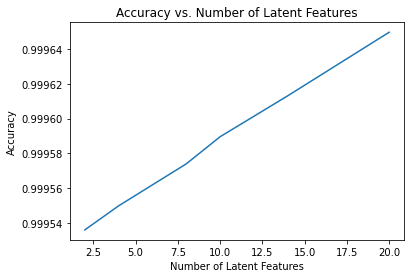

In [125]:
#Experimenting how many latent features would be best for the system
num_latent_features = [2,4,8,10,14,20]
mean_errors = []

for j in num_latent_features:
    #reshape U,S,V matrices
    u_train_new = u_train[:,0:j]
    s_train_new = np.diag(s_train[:j])
    vt_train_new = vt_train[0:j,]
    
    user_article_pred = np.dot(np.dot(u_train_new,s_train_new),vt_train_new)
    test_user_ids = test_matrix.index

    sum_error=[]
    for user in test_user_ids:
        ind = user-1
        user_pred = user_article_pred[ind]
        #error for each user
        diff = np.subtract(user_pred,test_matrix.loc[user])
        #sum of squared errors
        sum_diff = np.sum((np.abs(diff))**2)
        #store error for the users
        sum_error.append(sum_diff)
    #mean squared errors incurred for the number of latent features
    mean_errors.append(np.mean(sum_error))
    
#plot the accuracy on latent features
plt.plot(num_latent_features, 1 - np.array(mean_errors)/df_train.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features'); 